In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
# from d2l import torch as d2l

In [2]:
# d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip', '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

demo = False
if demo:
    pass
    # data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'input', 'dog-breed-identification')

In [3]:
"""Accumulator Class"""

class Accumulator:
    """accumulate on n variables"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

"""Timer Class"""
import time

class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`sec_minibatch_sgd`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


"""Animator Class"""
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
from IPython import display

def use_svg_display():
    """show svg image at Jupyter"""
    backend_inline.set_matplotlib_formats('svg')
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

'''Use Multiple GPUs'''

def try_gpu(i=0):
    """if exist. return gpu(i), otherwise return cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():
    """return all available GPU, if no GPU, return [cpu(),...]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

'''Accuracy Section'''
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

"""Data Loding"""
import shutil
import collections

def read_csv_labels(fname):
    """Read `fname` to return a filename to label dictionary."""
    with open(fname, 'r') as f:
        # Skip the file header line (column name)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)
    
def reorg_train_valid(data_dir, labels, valid_ratio):
    """Split the validation set out of the original training set."""
    # The number of examples of the class that has the fewest examples in the
    # training dataset
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # The number of examples per class for the validation set
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

def reorg_test(data_dir):
    """Organize the testing set for data loading during prediction."""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

In [4]:
# def reorg_dog_data(data_dir, valid_ratio):
#     labels = read_csv_labels(os.path.join(data_dir, 'labels.csv'))
#     reorg_train_valid(data_dir, labels, valid_ratio)
#     reorg_test(data_dir)

# batch_size = 32 if demo else 128
# valid_ratio = 0.1

# reorg_dog_data(data_dir, valid_ratio)

In [5]:
transform_train = torchvision.transforms.Compose([
    # random scale object from 0.08 to 1 (full size)
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0 / 4.0, 4.0 / 3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # random change brightness, contrast, saturation by 40% up and down
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                       saturation=0.4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [6]:
from PIL import Image

def label_map(labels):
    unique_labels = sorted(list(set(labels.values()))) #sorting is necessary to reproduce the order of the labelmap
    return dict(((label, i) for i, label in enumerate(unique_labels)))

class DogsDataset(torch.utils.data.Dataset):
    def __init__(self, is_train=False, transform=None):
        self.is_train = is_train
        self.images = sorted(os.listdir(os.path.join(data_dir, 'train' if self.is_train else 'test')))
        self.labels = read_csv_labels(os.path.join(data_dir, 'labels.csv'))
        self.label_map = label_map(self.labels)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image = Image.open(os.path.join(data_dir, 'train' if self.is_train else 'test', image_name))
        tensor = self.transform(image)
        if self.is_train:
            return tensor, self.label_map[self.labels[image_name[:-4]]]
        return tensor

# train_ds_full = DogsDataset(is_train=True, transform=transform_train)
# train_ds_full[0]


In [7]:
# train_ds, train_valid_ds = [
#     torchvision.datasets.ImageFolder(
#         os.path.join(data_dir, 'train_valid_test', folder),
#         transform=transform_train) for folder in ['train', 'train_valid']]

# valid_ds, test_ds = [
#     torchvision.datasets.ImageFolder(
#         os.path.join(data_dir, 'train_valid_test', folder),
#         transform=transform_test) for folder in ['valid', 'test']]

batch_size = 32 if demo else 128
valid_ratio = 0.1

train_ds_full = DogsDataset(is_train=True, transform=transform_train)

train_size = math.floor(len(train_ds_full) * (1 - valid_ratio))
valid_size = len(train_ds_full) - train_size

train_ds, valid_ds = torch.utils.data.random_split(train_ds_full, [train_size, valid_size])

train_iter, valid_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, valid_ds, train_ds_full)]

test_ds_full = DogsDataset(is_train=False, transform=transform_test)
test_iter = torch.utils.data.DataLoader(test_ds_full, batch_size, shuffle=False, drop_last=False)

## Fine Tune Pretrained Resnet34 on ImageNet

In [8]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), nn.ReLU(),
                                            nn.Linear(256, 120))
    finetune_net = finetune_net.to(devices[0])
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

In [9]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n

In [10]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD(
        (param for param in net.parameters() if param.requires_grad), lr=lr,
        momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 1.033, valid loss 1.249
838.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


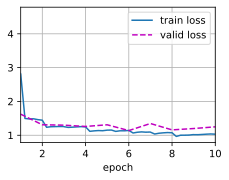

In [11]:
devices, num_epochs, lr, wd = try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

train loss 1.038
927.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


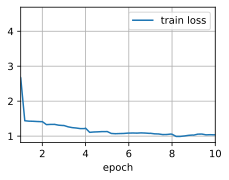

In [12]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

preds = []
for data in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(os.path.join(data_dir, 'test')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(list(train_ds_full.label_map.keys())) + '\n')
    for i, output in zip(ids, preds):
        f.write(
            i.split('.')[0] + ',' + ','.join([str(num)
                                              for num in output]) + '\n')

In [13]:
# import pandas as pd
# df = pd.DataFrame({'name': ['Raphael', 'Donatello'],
#                    'mask': ['red', 'purple'],
#                    'weapon': ['sai', 'bo staff']})
# df.to_csv("submission_cuda_test.csv", index=False)
# !rm submission_cuda_test.csv